In [1]:
import scvelo as scv
scv.settings.verbosity = 0
dataset = '../data/Organoids/organoids.h5ad'
label = 'cell_type'
exp_metrics = {}

In [2]:
import unitvelo as utv

(Running UniTVelo 0.1.dev1+g1881f6e)
2022-03-26 03:49:10


In [3]:
cluster_edges = [
    ("Stem cells", "TA cells"), 
    ("Stem cells", "Goblet cells")]

In [5]:
adata = scv.read(dataset)
cell_mapper = {
    '1': 'Enterocytes',
    '2': 'Enterocytes',
    '3': 'Enteroendocrine',
    '4': 'Enteroendocrine progenitor',
    '5': 'Tuft cells',
    '6': 'TA cells',
    '7': 'TA cells',
    '8': 'Stem cells',
    '9': 'Paneth cells',
    '10': 'Goblet cells',
    '11': 'Stem cells',
}
adata.obs['cell_type'] = adata.obs.som_cluster_id.map(cell_mapper).astype('str')
adata.write(dataset, compression='gzip')

## scVelo stochastic

  0%|          | 0/3831 [00:00<?, ?cells/s]

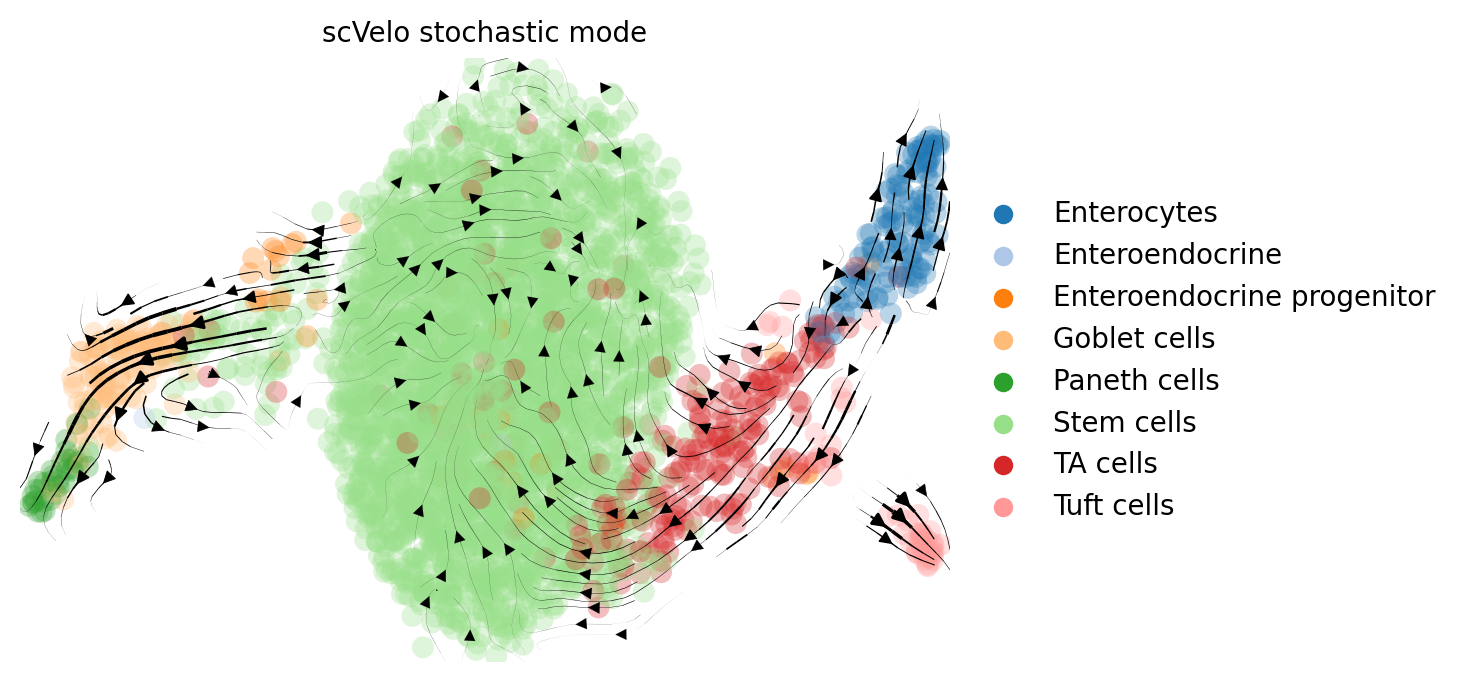

In [4]:
title = 'scVelo stochastic mode'
adata = scv.read(dataset)
adata.uns['datapath'] = dataset
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

scv.tl.velocity(adata, mode='stochastic')

scv.tl.velocity_graph(adata)
adata.uns['cell_type_colors'] = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a', '#d62728', '#ff9896']
scv.pl.velocity_embedding_stream(adata, color=label, dpi=200, title=title,
    legend_loc='far right')

In [5]:
scv.pp.neighbors(adata)
adata_velo = adata[:, adata.var.loc[adata.var['velocity_genes'] == True].index]
exp_metrics["model_dyn"] = utv.evaluate(adata_velo, cluster_edges, label, 'velocity')

# Cross-Boundary Direction Correctness (A->B)
{('Stem cells', 'TA cells'): -0.09643490177153952, ('Stem cells', 'Goblet cells'): 0.19285331884716267}
Total Mean: 0.048209208537811576
# In-cluster Coherence
{'Enterocytes': 0.8242295, 'Enteroendocrine': 0.9842765, 'Enteroendocrine progenitor': 0.87248236, 'Goblet cells': 0.8201039, 'Paneth cells': 0.839217, 'Stem cells': 0.7775167, 'TA cells': 0.8600152, 'Tuft cells': 0.9146982}
Total Mean: 0.8615673780441284


## scVelo dynamic

  0%|          | 0/460 [00:00<?, ?gene/s]

  0%|          | 0/3831 [00:00<?, ?cells/s]

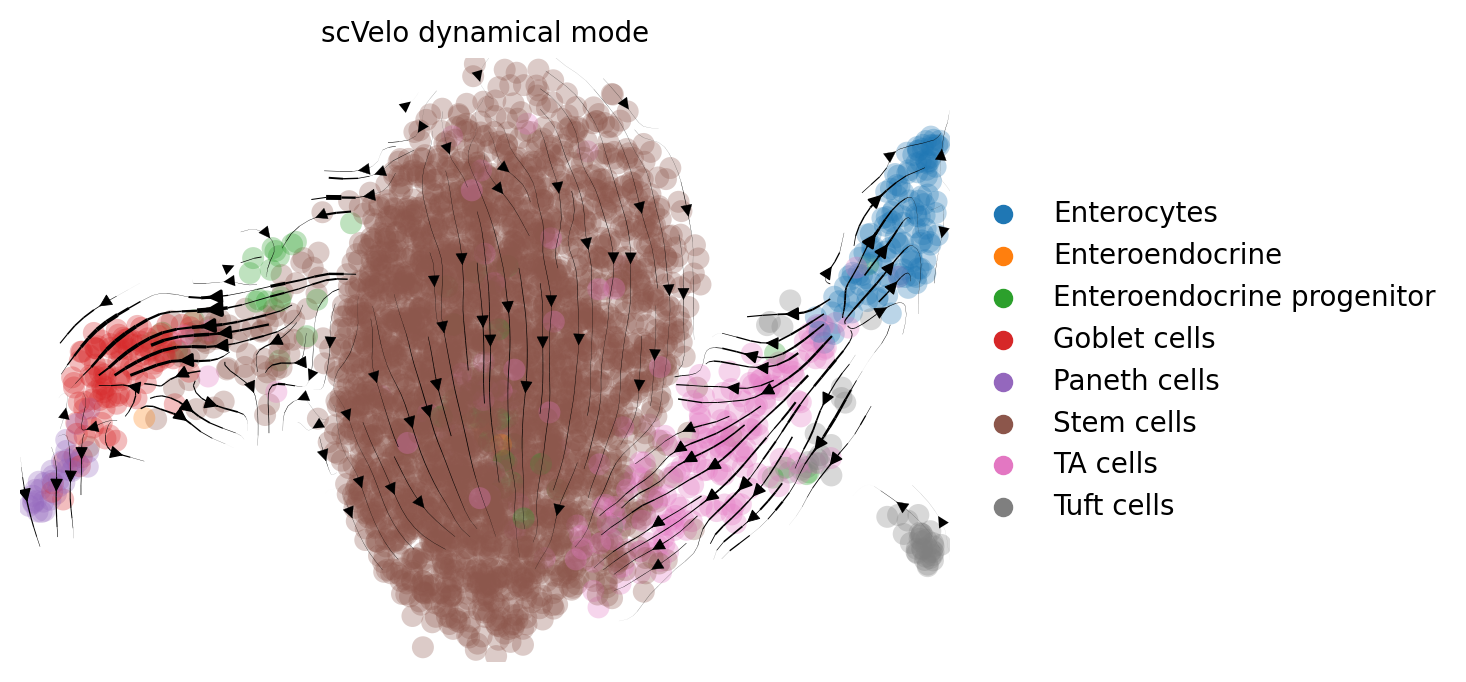

In [6]:
title = 'scVelo dynamical mode'
adata = scv.read(dataset)
adata.uns['datapath'] = dataset
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

scv.tl.recover_dynamics(adata, n_jobs=20)
scv.tl.velocity(adata, mode='dynamical')

scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding_stream(adata, color=label, dpi=200, title=title,
    legend_loc='far right')

In [7]:
scv.pp.neighbors(adata)
adata_velo = adata[:, adata.var.loc[adata.var['velocity_genes'] == True].index]
exp_metrics["model_dyn"] = utv.evaluate(adata_velo, cluster_edges, label, 'velocity')

# Cross-Boundary Direction Correctness (A->B)
{('Stem cells', 'TA cells'): -0.05054847599892724, ('Stem cells', 'Goblet cells'): 0.1815118434010139}
Total Mean: 0.06548168370104332
# In-cluster Coherence
{'Enterocytes': 0.7199606522659602, 'Enteroendocrine': 0.9669398810968225, 'Enteroendocrine progenitor': 0.843149997812989, 'Goblet cells': 0.6769492431605317, 'Paneth cells': 0.6947521817913263, 'Stem cells': 0.7846342928623831, 'TA cells': 0.8228564298220513, 'Tuft cells': 0.9238745465967951}
Total Mean: 0.8041396531761074


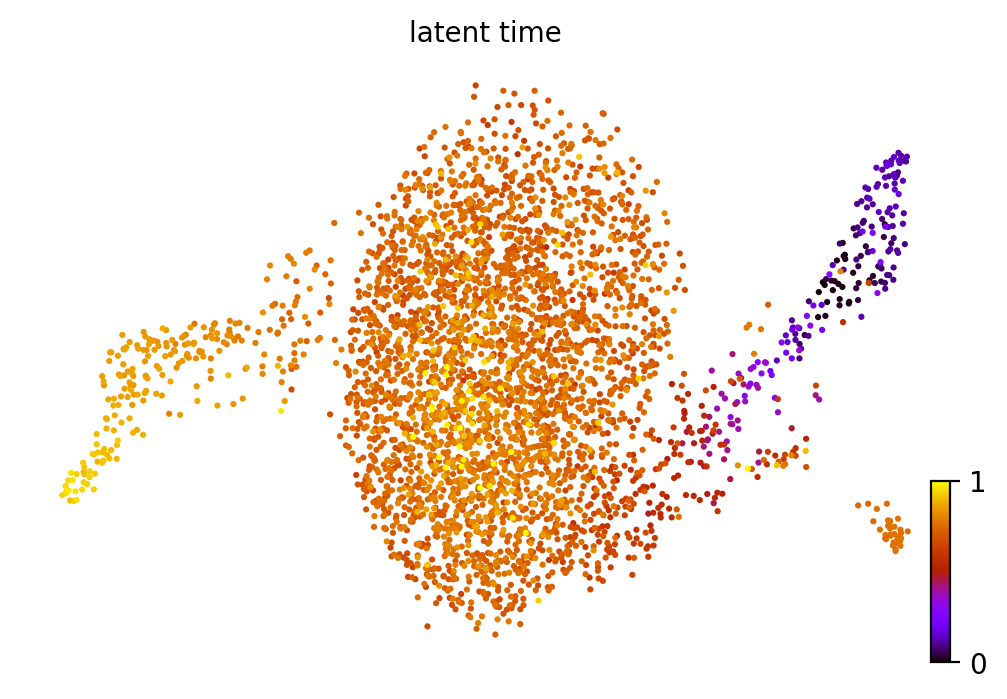

In [8]:
scv.tl.latent_time(adata)
scv.pl.scatter(adata, color='latent_time', color_map='gnuplot', size=20, dpi=200)

## UniTVelo

In [5]:
velo_config = utv.config.Configuration()
velo_config.R2_ADJUST = True
velo_config.IROOT = 'Stem cells'
velo_config.FIT_OPTION = '1'

-------> Model Configuration Settings <-------

 GPU: 2	FIG_DIR: ./figures/	BASE_FUNCTION: Gaussian	
 GENERAL: Curve	BASIS: None	N_TOP_GENES: 2000	
 OFFSET_GENES: False	FILTER_CELLS: False	EXAMINE_GENE: False	
 RESCALE_TIME: False	RESCALE_DATA: True	R2_ADJUST: True	
 IROOT: Stem cells	NUM_REPEAT: 1	FIT_OPTION: 1	
 DENSITY: SVD	REORDER_CELL: Soft_Reorder	AGGREGATE_T: True	
 ASSIGN_POS_U: False	WIN_SIZE: 50	LEARNING_RATE: 0.01	
 MAX_ITER: 10000	USE_RAW: False	RAW_GENES: False	

---> # of velocity genes used 433
---> # of velocity genes used 414
---> # of velocity genes used 414
---> Use Diffusion Pseudotime as initial.


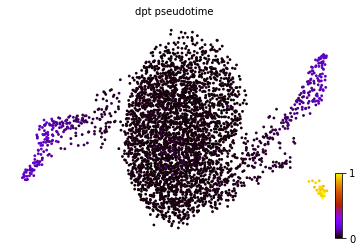

  0%|          | 0/10000 [00:00<?, ?it/s]

 | 971,922373965,536

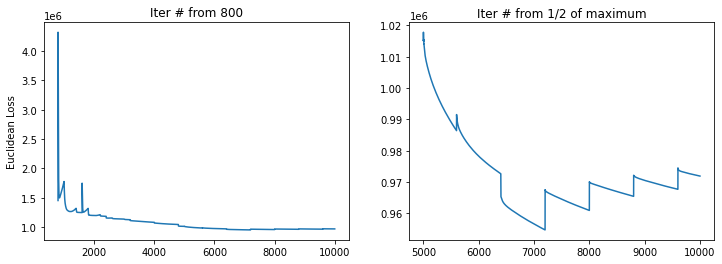

  0%|          | 0/3831 [00:00<?, ?cells/s]

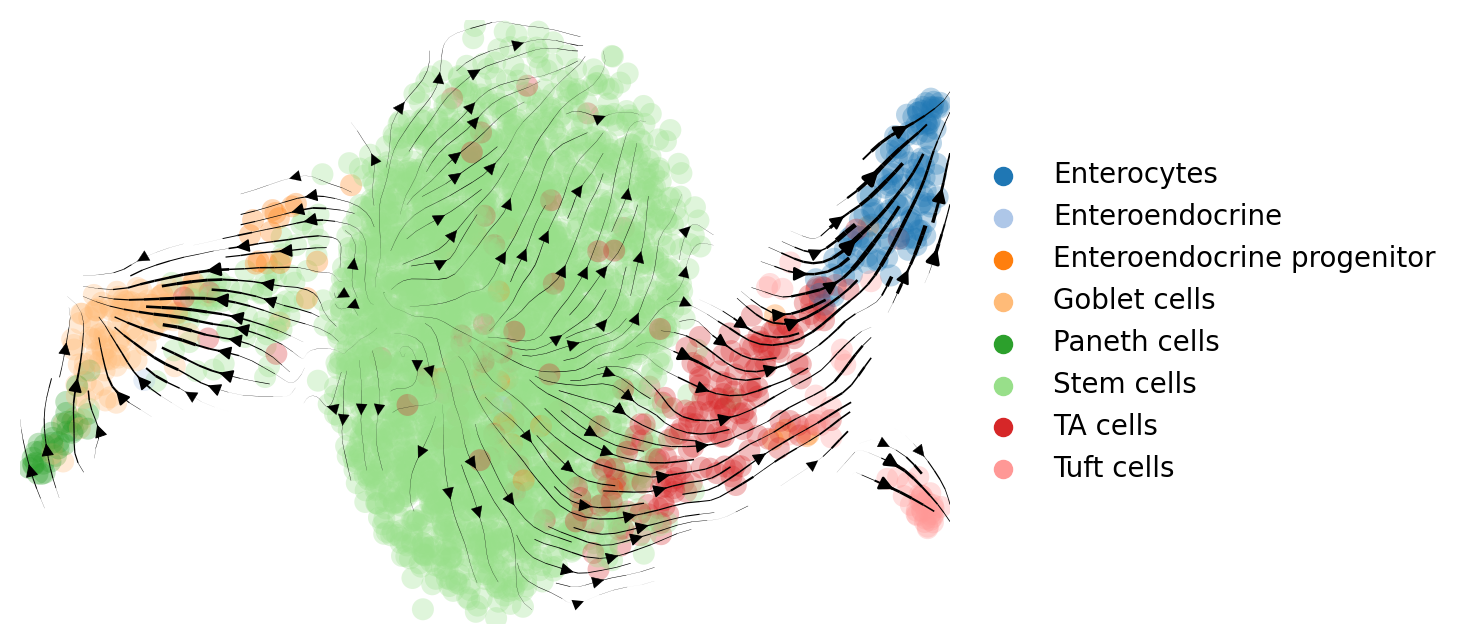

In [6]:
adata = utv.run_model(dataset, label, config_file=velo_config)
adata.uns['cell_type_colors'] = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a', '#d62728', '#ff9896']
scv.pl.velocity_embedding_stream(adata, color=adata.uns['label'], dpi=200, title='', 
    legend_loc='far right')

In [6]:
scv.pp.neighbors(adata)
adata_velo = adata[:, adata.var.loc[adata.var['velocity_genes'] == True].index]
exp_metrics["model_dyn"] = utv.evaluate(adata_velo, cluster_edges, label, 'velocity')

# Cross-Boundary Direction Correctness (A->B)
{('Stem cells', 'TA cells'): 0.31262964284932904, ('Stem cells', 'Goblet cells'): 0.8771414068365261}
Total Mean: 0.5948855248429276
# In-cluster Coherence
{'Enterocytes': 0.9587416014203398, 'Enteroendocrine': 0.996026293460715, 'Enteroendocrine progenitor': 0.9934198592433778, 'Goblet cells': 0.9895047323373496, 'Paneth cells': 0.9921224640938455, 'Stem cells': 0.9917418236918903, 'TA cells': 0.9589615744200212, 'Tuft cells': 0.9773175395058773}
Total Mean: 0.982229486021677


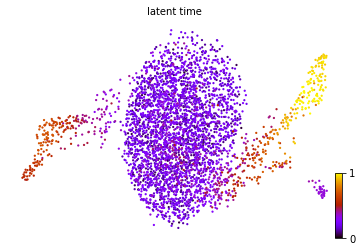

In [7]:
scv.tl.latent_time(adata, min_likelihood=None)
scv.pl.scatter(adata, color='latent_time', color_map='gnuplot', size=20)

In [7]:
subvar = adata.var.loc[adata.var['velocity_genes'] == True]
sub = adata[:, subvar.index]

Text(0.5, 1.0, 'Peak Time')

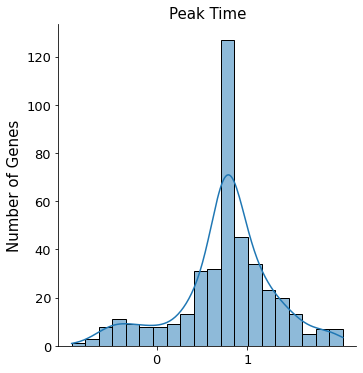

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.displot(sub.var['fit_t0'].values, kde=True, bins=20)
plt.xticks([0, 1], fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel('Number of Genes', fontsize=15)
plt.title('Peak Time', fontsize=15)

In [8]:
r2 = sub.var[['fit_t0', 'fit_r2']].sort_values(by=['fit_r2'], ascending=False)
r2

,fit_t0,fit_r2
index,,
Dgat1,0.773396,0.903234
Gsta4,0.953815,0.887514
Cyp2c66,0.763647,0.886013
Cyp2c65,0.761451,0.878404
Slc2a2,0.752518,0.873184
...,...,...
Edn1,1.871733,-0.015091
Tmem176b,0.774602,-0.017087
Gnai2,1.330305,-0.037739


Text(10.049999999999997, 0.5, '')

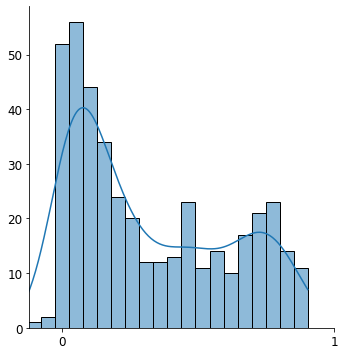

In [14]:
sns.displot(r2['fit_r2'].values, kde=True, bins=20)
plt.xlim([-0.12, 0.89])
plt.xticks([0, 1], fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('')
plt.ylabel('')

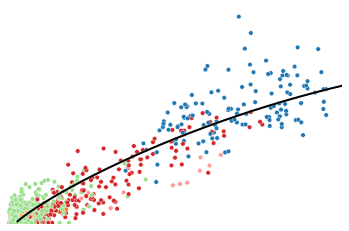

In [16]:
utv.pl.plot_range('Gsta4', adata, velo_config, 
    show_legend=False, show_ax=False, 
    t_left=0, t_right=1, time_metric='latent_time')

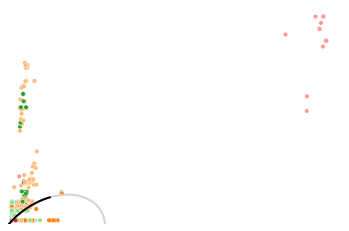

In [15]:
utv.pl.plot_range('Atp2a3', adata, velo_config, 
    show_legend=False, show_ax=False, 
    t_left=0, t_right=1, time_metric='latent_time')

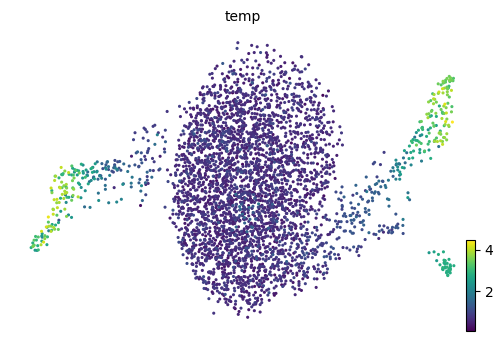

In [17]:
gene_name = 'Muc13'
adata.obs['temp'] = adata[:, gene_name].layers['Ms']
scv.pl.scatter(adata, color='temp', color_map='viridis', size=20, dpi=100)

## Detailed clusters

In [ ]:
cell_mapper = {
    '1': 'Enterocytes',
    '2': 'Enterocytes',
    '3': 'Enteroendocrine',
    '4': 'Enteroendocrine progenitor',
    '5': 'Tuft cells',
    '6': 'TA cells',
    '7': 'TA cells',
    '8': 'Stem cells',
    '9': 'Paneth cells',
    '10': 'Goblet cells',
    '11': 'Stem cells',
}
adata.obs['cell_type'] = adata.obs.som_cluster_id.map(cell_mapper).astype('str')

In [ ]:
scv.pl.velocity_embedding_stream(adata, color='cell_type', dpi=300, legend_loc='far right', title='', save='Organoids_Generalized Option 1_Detailed.png')

In [ ]:
cluster_edges = [
    ("Stem cells", "Goblet cells"), 
    ("Stem cells", "TA cells"),
    ("Enteroendocrine progenitor", "Goblet cells")]